This is an example of running a deep reinforcement learning algorithm. This file is created for a course at the University of Tokyo.

In the following, we run the simplest version of Deep Q-Learning.

# Network Architecture

In [1]:
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, action_dim)

        self.to(device)

    def forward(self, state):
        state = state.to(device)
        q1 = F.relu(self.l1(state))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1


# Agent Class

We then define the class for DQN. The update of the actor and critic is defined in "def train()".

In [2]:
class DQN(object):
    def __init__(
            self,
            state_dim,
            action_dim,
            discount=0.99,
            tau=0.005,
            target_update = 10
    ):

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-4)

        self.action_dim = action_dim
        self.discount = discount
        self.tau = tau

        self.target_update = target_update

        self.total_it = 0

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        with torch.no_grad():
          q_values = self.critic(state)
          q_values = q_values.squeeze(1)
          action = torch.argmax(q_values, dim=1)
        return action.cpu().numpy()[0]

    def train(self, replay_buffer, batch_size=128):
        self.total_it += 1

        # Sample replay buffer
        state, action_ind, next_state, reward, not_done = replay_buffer.sample(batch_size)

        # Move all tensors to CUDA
        state = state.to(device)
        action_ind = action_ind.to(device)
        next_state = next_state.to(device)
        reward = reward.to(device)
        not_done = not_done.to(device)

        # one_hot_action = torch.nn.functional.one_hot(action_ind, num_classes=self.action_dim).float()
        one_hot_action = torch.nn.functional.one_hot(action_ind, num_classes=int(self.action_dim)).float()

        with torch.no_grad():
            target_Q = self.critic_target(next_state)
            target_Q_max, _ = torch.max(target_Q, dim=1, keepdim=True)
            target_Q = reward + not_done * self.discount * target_Q_max

        current_Q = self.critic(state)

        # print('current_Q', current_Q.shape)
        # print('action_ind', action_ind.shape)
        # print('target_Q', target_Q.shape)
        current_Q_chosen = current_Q.gather(1, action_ind)
        # print('current_Q_chosen', current_Q_chosen.shape)

        critic_loss = torch.nn.functional.mse_loss(current_Q_chosen, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def save_model(self, iter, seed, env_name, foldername='./model/dqn'):
        try:
            import pathlib
            pathlib.Path(foldername).mkdir(parents=True, exist_ok=True)
            torch.save(self.actor.state_dict(),
                       foldername + '/DQN_'+ env_name +
                       '_seed' + str(seed) + '_iter' + str(iter) + '.pth')

            print('models is saved for iteration', iter)

        except:
            print("A result directory does not exist and cannot be created. The trial results are not saved")

    def load_model(self, iter, seed, env_name, foldername='model/dqn'):
        self.critic.load_state_dict(torch.load(foldername + '/DQN_'+ env_name +
                       '_seed' + str(seed) + '_iter' + str(iter) + '.pth'))

# Replay Buffer

The samples collected through trials and errors are stored in the replay buffer. "def sample()" is a function that randomly samples a batch of samples from the replay buffer.

In [3]:
class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (torch.tensor(self.state[ind], dtype=torch.float32),
          torch.tensor(self.action[ind], dtype=torch.int64), # Change dtype to torch.int64
          torch.tensor(self.next_state[ind], dtype=torch.float32),
          torch.tensor(self.reward[ind], dtype=torch.float32),
          torch.tensor(self.not_done[ind], dtype=torch.float32))


# Training and Evaluating Procedures

We define a function for evaluating the policy. When evaluating the trained policy, we evaluate the performance without the exploration noise.

In [12]:
def evaluate_greedy(env_test, agent, args, test_iter, test_n, state_dim, trial_seed):

    # env_test.reset(seed=1234 + test_n)
    # env_seed = (trial_seed - 1234) * 10000 + 1234 + test_n + 10000
    # state_test, info = env_test.reset()
    state_test, info = env_test.reset(seed=trial_seed + test_iter + test_n)

    return_epi_test = 0
    for t_test in range(int(args['max_episode_len'])):
        action_test = agent.select_action(np.reshape(state_test, (1, state_dim)))
        # print("====", action_test)
        action_test = int(action_test)
        # print("!!!", action_test)
        state_test2, reward_test, terminal_test, truncated, info = env_test.step(action_test)
        state_test = state_test2
        return_epi_test = return_epi_test + reward_test
        if terminal_test:
            break

    print('test_iter:{:d}, nn:{:d}, return_epi_test: {:d}'.format(int(test_iter), int(test_n),
                                                                      int(return_epi_test)))

    return return_epi_test

In [13]:
def train(env, env_test, agent, args, index, trial_seed):

    # Initialize replay memory
    total_step_cnt = 0
    epi_cnt = 0
    test_iter = 0
    return_test = np.zeros((np.ceil(int(args['total_step_num']) / int(args['eval_step_freq'])).astype('int') + 1))

    state_dim = env.observation_space.shape[0]
    action_dim =  env.action_space.n

    replay_buffer = ReplayBuffer(state_dim, 1)

    while total_step_cnt in range( int(args['total_step_num']) ):
        # Reset environment
        # state, info = env.reset()
        state, info = env.reset(seed=trial_seed + epi_cnt)

        ep_reward = 0
        T_end = False

        for t in range(int(args['max_episode_len'])):

            # Select action randomly or according to policy
            rnd_sample = np.random.uniform(0,1)
            if total_step_cnt < int(args['start_timesteps']) or rnd_sample < args['expl_eps']:
                action = env.action_space.sample()

            else:
                action = agent.select_action(np.reshape(state, (1, state_dim)))

            # print("---", action)
            action = int(action)
            # print("???", action)
            state2, reward, done, truncated, info_ = env.step(action)

            done = float(done) if t < int(args['max_episode_len']) else 1

            # Store data in replay buffer
            replay_buffer.add(state, action, state2, reward, done)

            # Move to the next state
            state = state2

            # Train agent after collecting sufficient data
            if total_step_cnt >= int(args['start_timesteps']):
                for i in range(int(args['update_freq'])):
                    agent.train(replay_buffer, int(args['batch_size']))

            if t == int(args['max_episode_len']) - 1:
                T_end = True

            ep_reward += reward
            total_step_cnt += 1

            # Evaluate the deterministic policy
            if total_step_cnt >= test_iter * int(args['eval_step_freq']) or total_step_cnt == 1:
                print('total_step_cnt', total_step_cnt)
                print('evaluating the deterministic policy...')
                for test_n in range(int(args['test_num'])):
                    return_epi_test = evaluate_greedy(env_test, agent, args, test_iter, test_n, state_dim, trial_seed)

                    # Store the average of returns over the test episodes
                    return_test[test_iter] = return_test[test_iter] + return_epi_test / float(args['test_num'])

                print('return_test[{:d}] {:d}'.format(int(test_iter), int(return_test[test_iter])))
                test_iter += 1

            if total_step_cnt % int(args['model_save_freq'])==0:
                    agent.save_model(iter=test_iter, seed=int(index), env_name=args['env'])


            if done or T_end:
                epi_cnt += 1
                print('| Reward: {:d} | Episode: {:d} | Total step num: {:d} |'.format(int(ep_reward), epi_cnt, total_step_cnt ))
                break

    return return_test

Main funciton. To manage the hyperparamters, we use argeparse.
We use a task in OpenAI Gym (https://gym.openai.com/).

In [66]:
import numpy as np
import gymnasium as gym

import argparse
import random

def set_all_seeds(seed=1234):
    """set all random seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# 在程序开始时设置种子
set_all_seeds(1234)

if torch.cuda.is_available():
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available, using CPU")

parser = argparse.ArgumentParser(description='provide arguments')

# run parameters
parser.add_argument('--env', help='choose the gym env- tested on {CartPole-v1}')
parser.add_argument('--env-id', type=int, default=0, help='choose the gym env- tested on {CartPole-v1}')
parser.add_argument('--random-seed', help='random seed for repeatability', default=1234)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=1000)
parser.add_argument('--trial-num', help='number of trials', default=3)
parser.add_argument('--total-step-num', help='total number of time steps', default=20000)
parser.add_argument('--eval-step-freq', help='frequency of evaluating the policy', default=2500)
parser.add_argument('--test-num', help='number of test episodes', default=10)

parser.add_argument('--result-file', help='file name for storing results from multiple trials',
                    default='/trials_dqn_')
parser.add_argument('--trial-idx', help='index of trials', default=0)
parser.add_argument('--model-save-freq', help='frequency of evaluating the policy', default=20000)
parser.add_argument('--model-folder',  default='./model/dqn')

parser.add_argument("--start_timesteps", default=5e4, type=int)  # How many time steps purely random policy is run for
parser.add_argument("--update_freq", default=1, type=int)  # Number of policy updates
parser.add_argument("--expl-eps", default=0.1, type=float)  # epsilon for epsilon-greedy
parser.add_argument("--batch-size", default=128, type=int)  # Batch size for both actor and critic
parser.add_argument("--discount", default=0.99, type=float)  # Discount factor
parser.add_argument("--tau", default=0.005, type=float)  # Target network update rate

args_tmp, unknown = parser.parse_known_args()

if args_tmp.env is None:
    env_dict = {0 : "CartPole-v1",
    }
    args_tmp.env = env_dict[args_tmp.env_id]
args = vars(args_tmp)

return_set = []
# for ite in range(int(args['trial_num'])):
#     print('Trial Number:', ite)

#     index = int(ite) + int(args['trial_idx'])
#     env = gym.make(args['env'])
#     env.reset(seed=1234)

#     np.random.seed(index )
#     env_test = gym.make(args['env'])
#     env_test.reset(seed=1234)

#     state_dim = env.observation_space.shape[0]
#     n_actions = env.action_space.n

#     agent = DQN(state_dim=state_dim, action_dim=n_actions, discount=args['discount'], tau=args['tau'])

#     step_R_i = train(env, env_test, agent, args, index)
#     return_set.append(step_R_i)

#     result_path = "./results/trials/dqn"
#     result_filename = result_path + args['result_file'] +  args['env'] +  '_trial_idx_' + str(index) + '.txt'
#     try:
#         import pathlib
#         pathlib.Path(result_path).mkdir(parents=True, exist_ok=True)
#         np.savetxt(result_filename, np.asarray(step_R_i))
#         print('The result of the trial no.' + str(index) +' was saved.')
#     except:
#         print("A result directory does not exist and cannot be created. The trial results are not saved")

for ite in range(int(args['trial_num'])):
    print('Trial Number:', ite)
    
    # set different seed for each trial
    trial_seed = int(args['random_seed']) + ite
    set_all_seeds(trial_seed)
    
    index = int(ite) + int(args['trial_idx'])
    
    env = gym.make(args['env'])
    env.action_space.seed(trial_seed)
    env.observation_space.seed(trial_seed)
    
    env_test = gym.make(args['env'])
    env_test.action_space.seed(trial_seed)
    env_test.observation_space.seed(trial_seed)
    
    state_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n
    
    agent = DQN(state_dim=state_dim, action_dim=n_actions, discount=args['discount'], tau=args['tau'])
    
    step_R_i = train(env, env_test, agent, args, index, trial_seed)
    return_set.append(step_R_i)
    
    result_path = "./results/trials/dqn"
    result_filename = result_path + args['result_file'] + args['env'] + '_trial_idx_' + str(index) + '.txt'
    try:
        import pathlib
        pathlib.Path(result_path).mkdir(parents=True, exist_ok=True)
        np.savetxt(result_filename, np.asarray(step_R_i))
        print('The result of the trial no.' + str(index) + ' was saved.')
    except:
        print("A result directory does not exist and cannot be created. The trial results are not saved")

Using CUDA device: NVIDIA GeForce RTX 3090
Trial Number: 0
total_step_cnt 1
evaluating the deterministic policy...
test_iter:0, nn:0, return_epi_test: 10
test_iter:0, nn:1, return_epi_test: 9
test_iter:0, nn:2, return_epi_test: 9
test_iter:0, nn:3, return_epi_test: 9
test_iter:0, nn:4, return_epi_test: 10
test_iter:0, nn:5, return_epi_test: 10
test_iter:0, nn:6, return_epi_test: 10
test_iter:0, nn:7, return_epi_test: 8
test_iter:0, nn:8, return_epi_test: 9
test_iter:0, nn:9, return_epi_test: 8
return_test[0] 9
| Reward: 35 | Episode: 1 | Total step num: 35 |
| Reward: 23 | Episode: 2 | Total step num: 58 |
| Reward: 17 | Episode: 3 | Total step num: 75 |
| Reward: 14 | Episode: 4 | Total step num: 89 |
| Reward: 19 | Episode: 5 | Total step num: 108 |
| Reward: 28 | Episode: 6 | Total step num: 136 |
| Reward: 19 | Episode: 7 | Total step num: 155 |
| Reward: 18 | Episode: 8 | Total step num: 173 |
| Reward: 59 | Episode: 9 | Total step num: 232 |
| Reward: 27 | Episode: 10 | Total ste

We plot the results of the training using matplotlib.

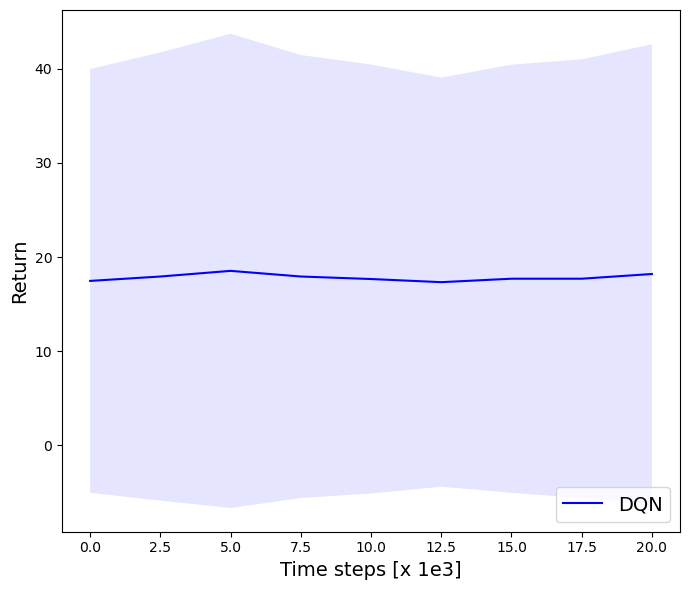

In [67]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib

figure(figsize=(7, 6))

t = np.arange(0, int(args['total_step_num']) + 1, int(args['eval_step_freq'])) * 0.001

mean = np.mean(np.asarray(return_set), axis=0)
std = np.std(np.asarray(return_set), axis=0)
color = 'b'
label = 'DQN'
plt.plot(t, mean, color, label=label)
plt.fill(np.concatenate([t, t[::-1]]), np.concatenate([mean - 1.9600 * std,
                                      (mean + 1.9600 * std)[::-1]]), alpha=.1, fc=color, ec='None')

plt.xlabel('Time steps [x 1e3]', fontsize=14)
plt.ylabel('Return', fontsize=14)
plt.legend(loc='lower right', fontsize=14)


plt.tight_layout()
plt.show()